In [ ]:
from datetime import datetime
import sys; sys.path.append('..')

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

from lib.data.santa_fe import load_santa_fe
from lib.models.mlp import MLP
from lib.utils.time_series import create_time_series_inputs_targets

# 2. Time-Series Prediction with a Neural Network

A time series is a sequence of observations, ordered in time. Forecasting involves training a model on historical data and using them to predict future observations. A simple example is a linear auto-regressive model. The linear auto-regressive (AR) model of a time-series $Z_t$ with $t = 1, 2,\ldots,\infty$ is given by:

$$
\hat{z}_t = a_1 z_{t-1} + a_2 z_{t-2} + \cdots + a_p z_{t-p},
$$

with $a_i \in \mathbb{R}$ for $i = 1,\ldots, p$ and $p$ the *model lag*. The prediction for a certain time $t$ is equal to a weighted sum of the previous values up to a certain lag $p$. In a similar way, the nonlinear variant (NAR) is described as:

$$
\hat{z}_t = f\left(z_{t-1}, z_{t-2}, \ldots, z_{t-p}\right).
$$

These processes can be depicted as follows (lag $p=2$):

<img alt="Schematic representation of the nonlinear auto-regressive model with lag p = 2." src=" 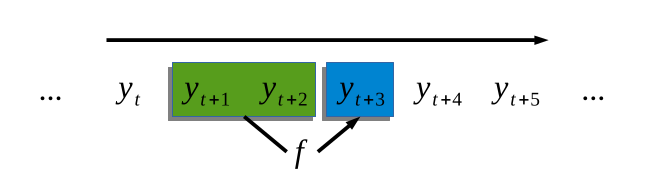"/>

Remark that in this way, the time-series identification can be written as a classical black-box regression modeling problem:

$$
\hat{y}_t = f(x_t) ,
$$

with $y_t = z_t$ and $x_t = [z_{t−1}, z_{t−2}, \ldots , z_{t−p}]$.

## 2.1 Sante Fe Dataset

The Santa Fe dataset is obtained from a chaotic laser which can be described as a nonlinear dynamical system. Given are 1000 training data points. The aim is to predict the next 100 points (it is forbidden to include these points in the training set!).

To load the test and training data, you can execute the cell below.

In [ ]:
train_set, val_set = load_santa_fe()

You can visualize the time series with the following code:

In [ ]:
# Create Matplotlib figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the training set in the left subplot
axes[0].set_title("Training set")
axes[0].plot(train_set)

# Plot the validation set in the right subplot
axes[1].set_title("Validation set")
axes[1].plot(val_set);

As you can see, the data spans a large range. To make it easier for our network to fit the data, we can *normalize* the data by subtracting the mean and dividing by the data's standard deviation. You can compute the mean and norm of a tensor `t` easily with the following method calls:

```python
t.mean()  # Returns the mean of t
t.std()  # Returns the standard deviation of t
```

Use this to normalize the training and validation data. Note that you should use the mean and std of the training set to normalize both the training *and* the validation dataset.

In [ ]:
## Put your code in this cell ##

## 2.2 Creating an MLP for Time-Series Prediction

An MLP for time-series prediction has $p$ inputs (the lag) and a single output. Using the `MLP` class from the previous exercise session (we have already imported it for you), create an MLP for time series prediction with a lag of 10 and 5 hidden neurons.

In [ ]:
## Create an MLP for time series prediction ##

## 2.3 Training the MLP

The training is done in feedforward mode:

$$
\hat{y}_k = w^T \tanh\left(V[y_{k−1}, y_{k−2},\ldots, y_{k−p}] + \beta\right).
$$

We pass in $p$ successive data points from the time series and the model should predict the next data point. By comparing the predicted output with the true data point (e.g., via mean-squared error), we can compute a loss and train the network.

So, before we can start training, we will need a bunch of successive data points of length $p$ (the inputs), along with the data point that comes right after each sequence (the targets). To create these inputs and targets, you can use the provided function `create_time_series_inputs_targets()`. For example, to create a dataset with inputs and the corresponding targets for a network with a lag of 10, you can run the following code:

```python
inputs, targets = create_time_series_inputs_targets(my_time_series, 10)
```

where `my_time_series` is your time series (1D tensor). Make sure you understand what the function does by trying it out on a small self-made toy example.

In [ ]:
## Create train_inputs and train_targets from the training dataset ##

The `train_inputs` you have created in the previous cell can be used as a batch of training input data for the MLP. When passing this to the MLP, you will get a batch of predicted outputs, which can be compared with the ground-truth `train_targets`. From this, we can compute a loss value that can be optimized with gradient descent.

Now, write a `training_step()` function, based on the one from notebook `2_mlp.ipynb` of the previous exercise session. Define a suitable optimizer and loss function. Also define a `SummaryWriter` for the TensorBoard logs.

In [ ]:
## Write your training_step() function here ##

In [ ]:
## Define optimizer, loss function and writer here ##

Now you can train your network with the following loop. Don't forget to define the number of epochs. Note that `train_inputs` and `train_targets` should have been created with `create_time_series_inputs_targets()`.

In [ ]:
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(mlp, train_inputs, train_targets, loss_fn, optimizer, writer, epoch)

## 2.4 Making Time-Series Predictions

In order to make predictions, the trained network is used in an iterative way as a recurrent network:

$$
\hat{y}_k = w^T \tanh\left(V[\hat y_{k−1}, \hat y_{k−2},\ldots, \hat y_{k−p}] + \beta\right).
$$

As you can see, predictions from a previous time step ($\hat y_{k−*}$) are used to predict the output of the current time step. Indeed, to run a trained MLP for predicting a new time series, we must run the model *recurrently*. Complete the following implementation.

```python
@torch.no_grad()
def run_recurrent_model(model, x_0, num_iters):
    """
    Create a time series by recurrenctly feeding the output back into the input.
    """
    # Create a tensor to store the outputs in
    outputs = torch.zeros(num_iters)

    x_t = x_0
    for t in range(num_iters):
        # Compute the next value
        y_t = model(x_t)

        # Store the output
        outputs[t] = y_t

        # Create the input for the next time
        x_t = torch.cat([x_t[??], y_t]) # Shift the previous input and concatenate the output

    return outputs
```

In [ ]:
## Paste your implementation in this cell ##

In order to evaluate your MLP on the validation set, you can pass in the training dataset in `run_recurrent_model()` and compare the output with the time series in the validation set. Use the mean squared error for your comparison.

In [ ]:
## Write your evaluation code in this cell ##

## 2.5 Exercise

Train an MLP with one hidden layer **after normalizing** the Santa Fe dataset. Investigate the model performance with different lags and number of neurons. Explain clearly how you tune the parameters and what the influence is on the final prediction. Which combination of parameters gives the best performance on the test set?